In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import seaborn

pd.set_option('display.max_rows', 500)



In [2]:
import re
from scipy.stats import entropy

df = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",")
df = df.set_index("palabra")


fnorm_vars = [c for c in df.columns if re.match(r'fnorm_.*', c)]
cant_palabras = [c for c in df.columns if re.match(r'.*Palabras$', c)]
cant_personas = [c for c in df.columns if re.match(r'.*Personas$', c)]

In [3]:
from iv_helpers import simulated_shuffled_entropy_multinomial

fn = lambda ws: simulated_shuffled_entropy_multinomial(ws, len(cant_palabras))

df["entropy_palabras"] = df[cant_palabras].apply(entropy, axis=1, raw=True)
df["entropy_personas"] = df[cant_personas].apply(entropy, axis=1, raw=True)
df["shuffled_entropy_personas"] = df.cantUsuariosTotal.apply(fn)
df["shuffled_entropy_palabras"] = df.cantPalabra.apply(fn)

In [4]:
print df.cantUsuariosTotal.min()
print df.cantPalabra.min()

6
41


In [5]:
cantPalabrasTotales = sum(df.cantPalabra)
df['fnormArgentina'] = df['cantPalabra']/cantPalabrasTotales

In [6]:
df.fnormArgentina


palabra
a                    2.632803e-02
aa                   2.267000e-05
aaa                  8.730575e-05
aaaca                2.387432e-07
aaadentro            3.342405e-07
aaag                 3.979054e-07
aaaggg               3.979054e-07
aaah                 4.978592e-05
aaahh                3.597065e-06
aaahhh               1.037737e-05
aaahi                2.546594e-07
aaahora              2.493540e-07
aaai                 1.522651e-06
aaaii                2.758811e-07
aaaiii               5.889000e-07
aaaj                 6.525648e-07
aaajaja              2.705757e-07
aaajajaja            4.934027e-07
aaajajajaja          4.509594e-07
aaajajajajaja        5.040135e-07
aaajajajajajaja      2.864919e-07
aaajajajajajajaja    2.334378e-07
aaal                 1.596927e-06
aaala                8.541702e-07
aaalgo               9.761946e-07
aaalguien            3.501567e-07
aaall                2.334378e-07
aaalta               1.013332e-06
aaalto               1.050470e-06
aaam  

In [7]:
df.entropy_personas.describe()

count    75878.000000
mean         2.842564
std          0.409441
min          0.000000
25%          2.796571
50%          2.959232
75%          3.059217
max          3.135044
Name: entropy_personas, dtype: float64

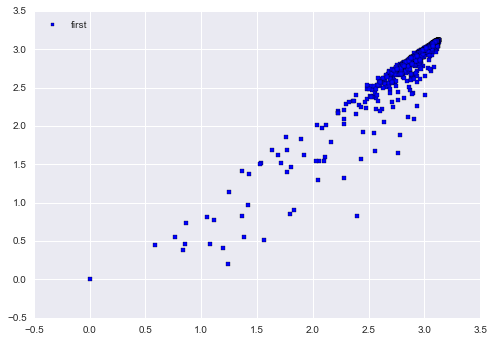

In [8]:
import matplotlib.pyplot as plt

x = df.entropy_personas[:1000]
y = df.entropy_palabras[:1000]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=10, c='b', marker="s", label='first')
plt.legend(loc='upper left');
plt.show()

In [9]:
df.cantPalabra.describe()

count    7.587800e+04
mean     2.484080e+03
std      6.000610e+04
min      4.100000e+01
25%      6.900000e+01
50%      1.390000e+02
75%      4.300000e+02
max      7.509160e+06
Name: cantPalabra, dtype: float64

Si le aplico el logaritmo a la cantidad de la Palabra, ya no tiene tanta importancia la cantidad y por lo tanto, las palabras palabras comunes como **que**, **y**,**el**,etc. dejan de tener tanto valor de información

In [10]:
import math
df['normCantPalabras']=(df.cantPalabra.apply(math.log,args=(2,))-df.cantPalabra.apply(math.log,args=(2,)).min())/(df.cantPalabra.apply(math.log,args=(2,)).max()-df.cantPalabra.apply(math.log,args=(2,)).min())
df['normCantPersonas']=(df.cantUsuariosTotal.apply(math.log,args=(2,))-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())/(df.cantUsuariosTotal.apply(math.log,args=(2,)).max()-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())

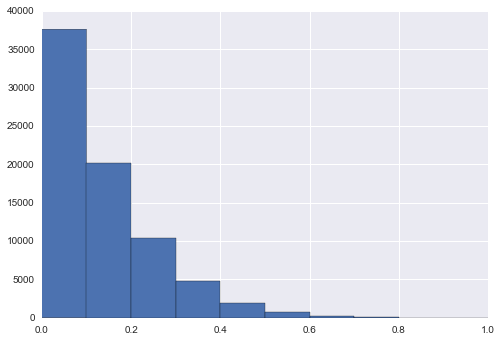

In [11]:
df.normCantPalabras.hist()

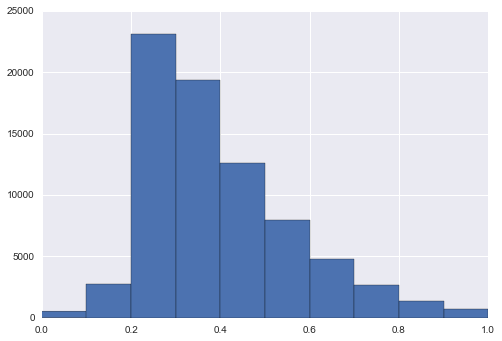

In [12]:
df.normCantPersonas.hist()

In [13]:
from iv_helpers import lugares
places = lugares()
print len(places)
df['esLugar'] = np.where(df.index.str.decode(encoding='utf-8').isin(places),'lugar','ok')

3006


### Normalizo el valor de la cantidad de ocurrencias de una palabra y de usuarios que la utilizan.

$$ norm_{CantPalabras} = \frac{log_2(\#Palabra)- min(log_2(\#Palabra))}{max(log_2(\#Palabra)) - min(log_2(\#Palabra))}$$

$$norm_{CantPersonas} = \frac{log_2(\#Usuarios)- min(log_2(\#Usuarios))}{max(log_2(\#Usuarios)) - min(log_2(\#Usuarios))}$$

De esta forma, estos dos valores están en el rango 0-1

La métrica llamada $InformationValue_{PersonasPalabras}$

$$InformationValue_{PersonasPalabras} =  norm_{CantPalabras} * norm_{CantPersonas} * (\widehat{H}_{personas} - H_{personas}) * (\widehat{H}_{palabras} - H_{palabras})$$

donde $\widehat{H}$ es la entropía con las cantidades distribuidas uniformemente y H es la entropía común

$$ InformationValue_{PersonasPalabras} =  norm_{CantPalabras} * norm_{CantPersonas} * (\widehat{H}_{personas} - H_{personas}) * (\widehat{H}_{palabras} - H_{palabras}) $$

In [14]:
import math

df["information_value_palabras"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas)
# df["information_value_personas_palabras"] = (df.cantUsuariosTotal.apply(math.log,args=(2,))) * (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
# df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)

#df["information_value_FnormMax"] = (df.FnormMax) * (df.shuffled_entropy - df.entropy)

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
df['rankPalabras'] = df['information_value_palabras'].rank(ascending=False).astype('int64')
df['rankPersonas'] = df['information_value_personas'].rank(ascending=False).astype('int64')
df['rankPalabras_Personas'] = df['information_value_personas_palabras'].rank(ascending=False).astype('int64')


palabrasPersonas = [c for c in df.columns if re.match(r'.*PalabrasPersonas', c)]
# df = df.set_index('palabra')
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
df.iloc[:1000][['cantPalabra','esLugar','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','normCantPersonas','normCantPalabras','shuffled_entropy_personas','entropy_personas']]

,cantPalabra,esLugar,cantUsuariosTotal,provinciaFnormMax,rankPalabras,rankPersonas,rankPalabras_Personas,normCantPersonas,normCantPalabras,shuffled_entropy_personas,entropy_personas
palabra,,,,,,,,,,,
chivilcoy,4074,lugar,469,buenosaires,4,3,1,0.532714,0.379500,3.121189,0.558161
oberá,4322,lugar,378,misiones,3,4,2,0.506352,0.384377,3.105868,0.569656
ushuaia,14966,lugar,1006,tierradelfuego,1,53,3,0.625981,0.486874,3.127818,1.453279
ush,2137,ok,465,tierradelfuego,11,5,4,0.531668,0.326256,3.100293,0.362702
obera,2106,lugar,410,misiones,17,11,5,0.516283,0.325050,3.104802,0.543877
breñas,2590,lugar,170,chaco,6,2,6,0.408690,0.342121,3.098506,0.232404
viedma,6584,lugar,666,rionegro,7,54,7,0.575573,0.419112,3.123175,1.294115
bragado,2805,lugar,294,buenosaires,9,10,8,0.475637,0.348702,3.091819,0.619135
logroño,2592,lugar,132,larioja,5,1,9,0.377771,0.342184,3.062510,0.089018


## Hago un dataframe con las palabras candidatas, cada una con las cantidades de ocurrencias por provincia de forma ordenada

In [15]:
cant = [c for c in df.columns if re.match(r'.*Palabras$', c) and (not re.match(r'.*norm', c) ) and (not re.match(r'.*rank', c) )]

dfCant = df[cant]
# Palabras candidatas según la AAL
palabras = ["quedarla","mitaí","angá","yungas","mensajeras","yarco","yarca",
"malpegar","malpegue","malpegada","tareferos","hartante","guaracha","esar","ñeri",
"piadina","chombi","achilata","pollerear","juntadera","pachata","chamigo","chamiga",
"chaque","pichar","tortita","guaso","guasa","comparsero","comparsera","sina","lape","veme","porronear",
"fajita","jia","jía","asada","asar","manso","cora","cumpa","pingo","charro","pinchila","oyo","ura","yuto",
"yagua","cantobar","cha","bombolo","bombola","yafu","jal","gatera","atina",
"guampudo","guampuda","mamila","chui","tico"]
top_n = 23
dfCant = dfCant.loc[palabras].dropna()
dfLargestNum = pd.DataFrame({col: dfCant.T[col].nlargest(top_n).tolist() 
                  for n, col in enumerate(dfCant.T)}).T
dfLargestNum

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
achilata,143.0,20.0,18.0,8.0,6.0,3.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
angá,36.0,34.0,14.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
asada,265.0,248.0,27.0,19.0,15.0,15.0,13.0,13.0,13.0,12.0,...,7.0,6.0,6.0,5.0,4.0,3.0,3.0,3.0,3.0,2.0
asar,324.0,187.0,23.0,13.0,9.0,8.0,8.0,7.0,6.0,5.0,...,3.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0
atina,106.0,6.0,5.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bombola,160.0,3.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bombolo,123.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cantobar,149.0,11.0,9.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cha,730.0,141.0,94.0,86.0,75.0,71.0,70.0,68.0,68.0,66.0,...,58.0,58.0,52.0,51.0,49.0,42.0,42.0,41.0,38.0,32.0
chamiga,146.0,58.0,47.0,36.0,9.0,9.0,8.0,6.0,5.0,4.0,...,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Hago un dataframe con las palabras candidatas, cada una con las provincias ordenadas según cuantas veces ocurre una palabra en cada una de ellas

In [16]:
dfCant = dfCant.loc[palabras].dropna()
dfLargestProv = pd.DataFrame({col: dfCant.T[col].nlargest(top_n).index.tolist() 
                  for n, col in enumerate(dfCant.T)}).T

dfLargestProv

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
achilata,tucumanPalabras,santiagoPalabras,catamarcaPalabras,saltaPalabras,lariojaPalabras,jujuyPalabras,santacruzPalabras,rionegroPalabras,tierradelfuegoPalabras,cordobaPalabras,...,sanjuanPalabras,buenosairesPalabras,neuquenPalabras,misionesPalabras,formosaPalabras,entreriosPalabras,corrientesPalabras,chubutPalabras,chacoPalabras,mendozaPalabras
angá,corrientesPalabras,formosaPalabras,chacoPalabras,misionesPalabras,santafePalabras,santacruzPalabras,buenosairesPalabras,rionegroPalabras,tierradelfuegoPalabras,santiagoPalabras,...,mendozaPalabras,neuquenPalabras,catamarcaPalabras,lariojaPalabras,lapampaPalabras,jujuyPalabras,entreriosPalabras,cordobaPalabras,chubutPalabras,tucumanPalabras
asada,mendozaPalabras,sanjuanPalabras,santafePalabras,sanluisPalabras,corrientesPalabras,lariojaPalabras,chacoPalabras,chubutPalabras,cordobaPalabras,neuquenPalabras,...,santacruzPalabras,catamarcaPalabras,santiagoPalabras,lapampaPalabras,jujuyPalabras,misionesPalabras,rionegroPalabras,formosaPalabras,tierradelfuegoPalabras,tucumanPalabras
asar,sanjuanPalabras,mendozaPalabras,buenosairesPalabras,cordobaPalabras,entreriosPalabras,lapampaPalabras,sanluisPalabras,neuquenPalabras,santafePalabras,lariojaPalabras,...,santiagoPalabras,tucumanPalabras,catamarcaPalabras,jujuyPalabras,formosaPalabras,rionegroPalabras,tierradelfuegoPalabras,chubutPalabras,misionesPalabras,santacruzPalabras
atina,mendozaPalabras,entreriosPalabras,santiagoPalabras,sanluisPalabras,rionegroPalabras,neuquenPalabras,jujuyPalabras,lariojaPalabras,santafePalabras,catamarcaPalabras,...,lapampaPalabras,misionesPalabras,formosaPalabras,corrientesPalabras,saltaPalabras,sanjuanPalabras,santacruzPalabras,chubutPalabras,chacoPalabras,tierradelfuegoPalabras
bombola,formosaPalabras,corrientesPalabras,sanjuanPalabras,santafePalabras,misionesPalabras,buenosairesPalabras,neuquenPalabras,tierradelfuegoPalabras,santiagoPalabras,santacruzPalabras,...,mendozaPalabras,catamarcaPalabras,lariojaPalabras,lapampaPalabras,jujuyPalabras,entreriosPalabras,cordobaPalabras,chubutPalabras,chacoPalabras,tucumanPalabras
bombolo,formosaPalabras,tierradelfuegoPalabras,corrientesPalabras,buenosairesPalabras,neuquenPalabras,santiagoPalabras,santafePalabras,santacruzPalabras,sanluisPalabras,sanjuanPalabras,...,misionesPalabras,catamarcaPalabras,lariojaPalabras,lapampaPalabras,jujuyPalabras,entreriosPalabras,cordobaPalabras,chubutPalabras,chacoPalabras,tucumanPalabras
cantobar,neuquenPalabras,rionegroPalabras,santafePalabras,buenosairesPalabras,cordobaPalabras,lapampaPalabras,tierradelfuegoPalabras,santacruzPalabras,sanluisPalabras,mendozaPalabras,...,jujuyPalabras,formosaPalabras,saltaPalabras,sanjuanPalabras,entreriosPalabras,corrientesPalabras,chubutPalabras,santiagoPalabras,chacoPalabras,tucumanPalabras
cha,formosaPalabras,jujuyPalabras,buenosairesPalabras,saltaPalabras,santacruzPalabras,santafePalabras,corrientesPalabras,lapampaPalabras,rionegroPalabras,mendozaPalabras,...,cordobaPalabras,chacoPalabras,chubutPalabras,tierradelfuegoPalabras,catamarcaPalabras,sanluisPalabras,tucumanPalabras,santiagoPalabras,misionesPalabras,entreriosPalabras
chamiga,corrientesPalabras,formosaPalabras,misionesPalabras,chacoPalabras,santafePalabras,entreriosPalabras,tierradelfuegoPalabras,rionegroPalabras,cordobaPalabras,lapampaPalabras,...,catamarcaPalabras,neuquenPalabras,jujuyPalabras,santiagoPalabras,buenosairesPalabras,mendozaPalabras,sanjuanPalabras,saltaPalabras,lariojaPalabras,tucumanPalabras


In [18]:
df.sort_values(by='information_value_personas_palabras',ascending=False,inplace=True)
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas']]
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','entropy_palabras','entropy_personas']].to_csv('resumido.csv')

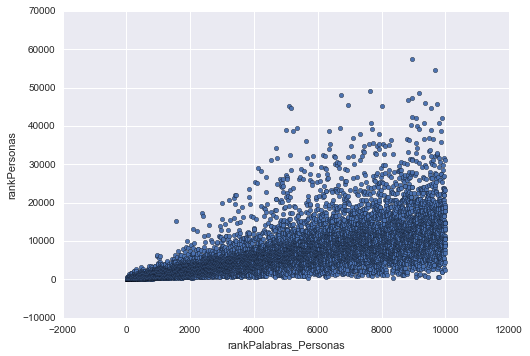

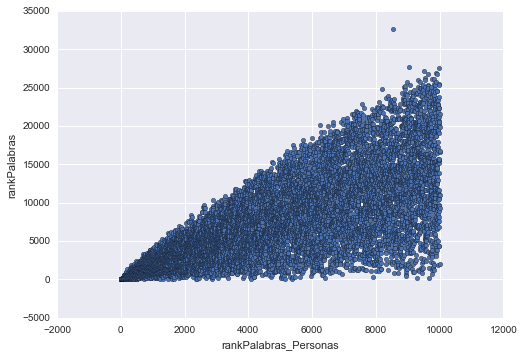

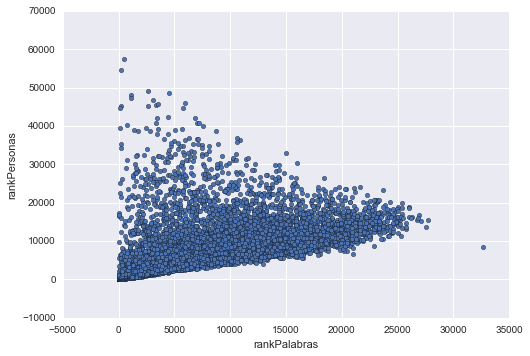

In [19]:
df.iloc[:10000].plot.scatter(x='rankPalabras_Personas',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='rankPalabras_Personas',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='rankPalabras',y='rankPersonas')

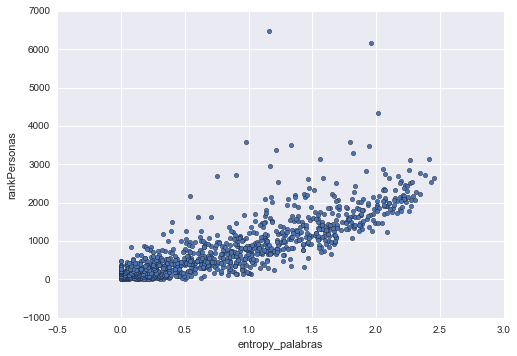

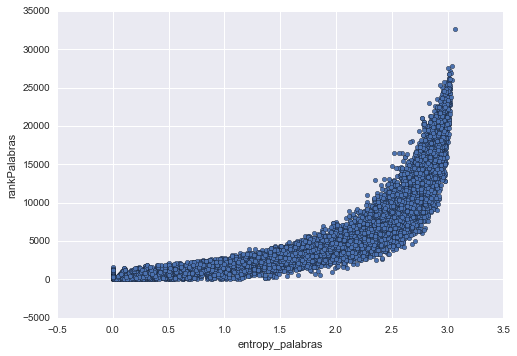

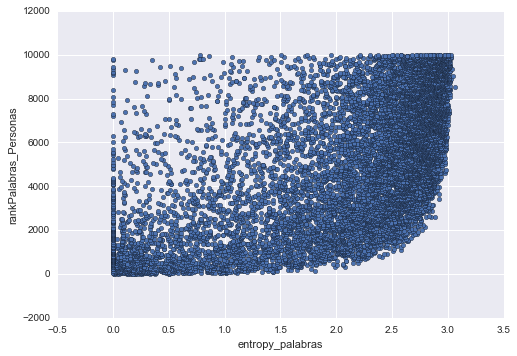

In [20]:
df.iloc[:1000].plot.scatter(x='entropy_palabras',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='entropy_palabras',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='entropy_palabras',y='rankPalabras_Personas')

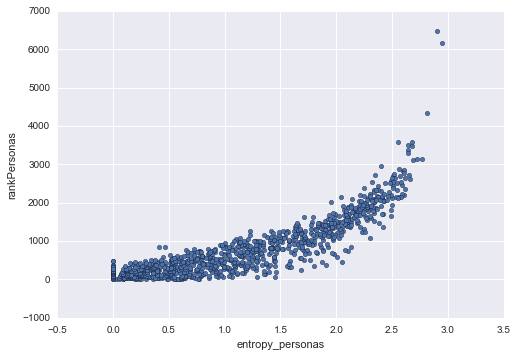

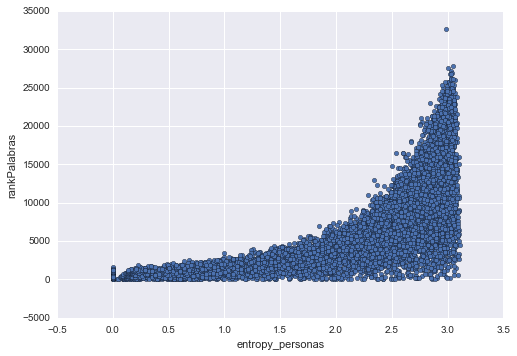

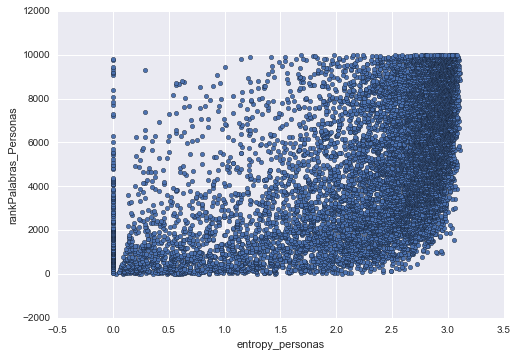

In [21]:
df.iloc[:1000].plot.scatter(x='entropy_personas',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='entropy_personas',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='entropy_personas',y='rankPalabras_Personas')

## Guardo los listados (resumidos, y extendidos) ordenados en base a las dos médidas de información

In [22]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_palabras_resumida.csv')
df.to_csv('ivalue_entropia_palabras.csv')

df.sort_values(by="information_value_personas", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_personas_resumida.csv')
df.to_csv('ivalue_entropia_personas.csv')

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed = resumed[['cantPalabra','esLugar','cantUsuariosTotal','fnormArgentina','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas']]
resumed.to_csv('ivalue_entropia_personas_palabras_resumida.csv')


df.to_csv('ivalue_entropia_personas_palabras.csv')

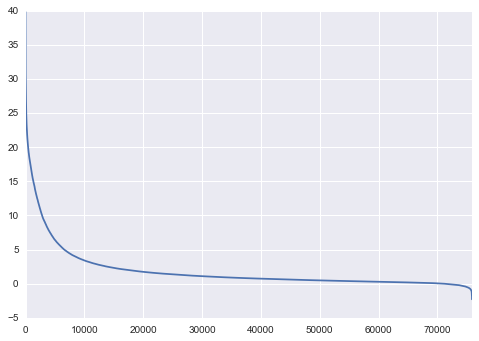

In [23]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
df2 = df.reset_index()
df2.information_value_palabras.plot.line()

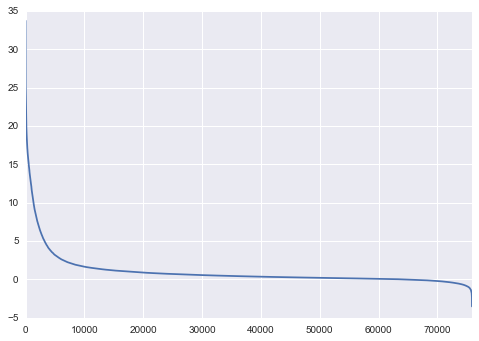

In [24]:
df.sort_values(by="information_value_personas", ascending=False, inplace=True)
df2 = df.reset_index()

df2.information_value_personas.plot.line()

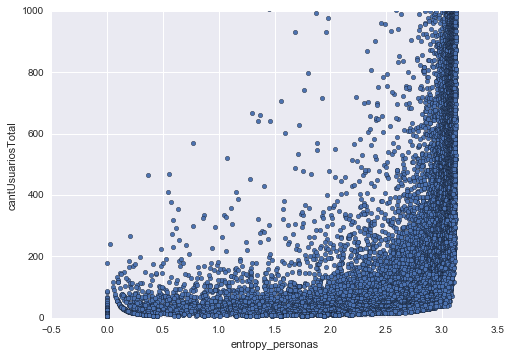

In [25]:
import seaborn
df.plot.scatter(x="entropy_personas", y="cantUsuariosTotal", ylim=[0, 1000])

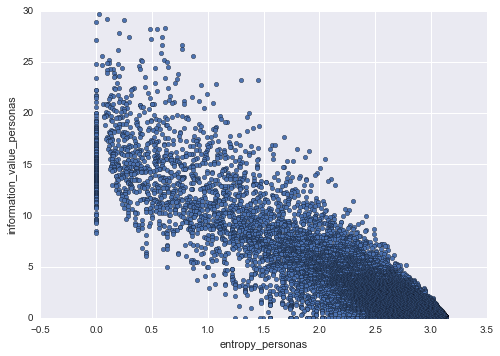

In [26]:
import seaborn
df.plot.scatter(x="entropy_personas", y="information_value_personas", ylim=[0, 30])

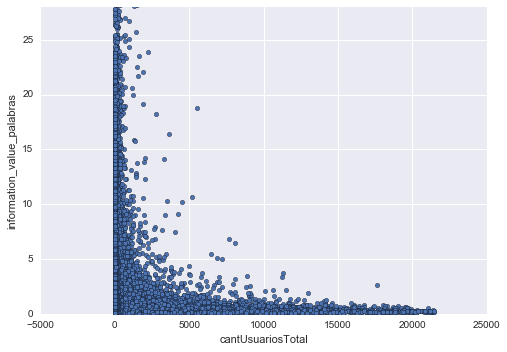

In [27]:
import seaborn
df.plot.scatter(x="cantUsuariosTotal", y="information_value_palabras", ylim=[0, 28])

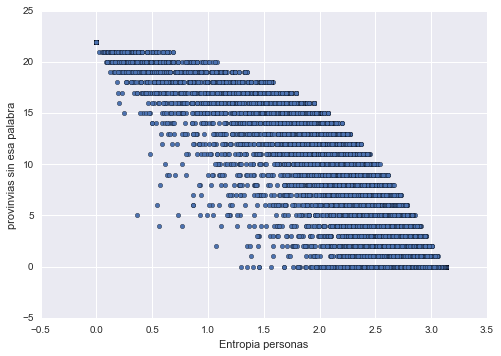

In [28]:
plt.figure(1)
df.plot.scatter(x="entropy_personas", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia personas")
plt.ylabel("provinvias sin esa palabra")


plt.show()


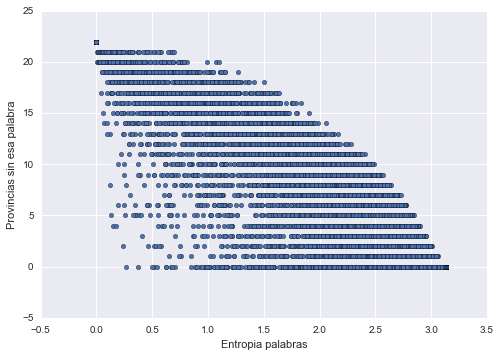

In [29]:

plt.figure(2)
df.plot.scatter(x="entropy_palabras", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia palabras")
plt.ylabel("Provincias sin esa palabra")

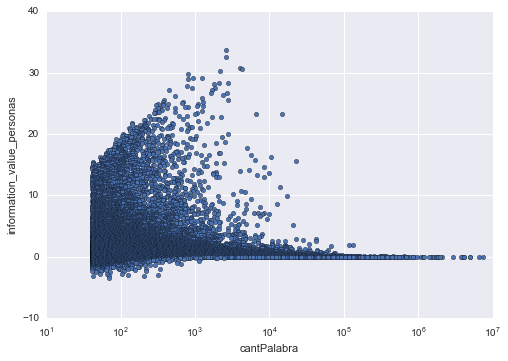

In [30]:
import seaborn
df.plot.scatter(y="information_value_personas", x="cantPalabra", logx=True)

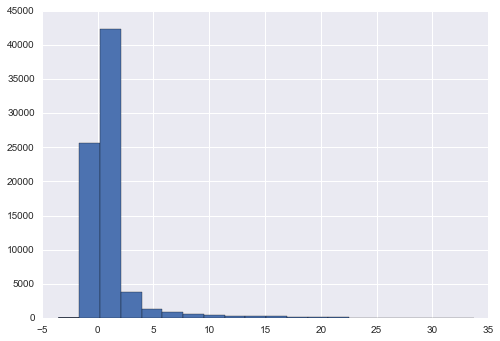

In [31]:
df.information_value_personas.hist(bins=20)

In [32]:
resumed[df.information_value_personas < 0].iloc[:100]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,cantPalabra,esLugar,cantUsuariosTotal,fnormArgentina,provinciaFnormMax,rankPalabras,rankPersonas,rankPalabras_Personas
palabra,,,,,,,,
solterooo,64,ok,60,3.395459e-07,formosa,75870,75612,22967
apostador,73,ok,68,3.872946e-07,jujuy,75658,75753,25089
volverlas,57,ok,57,3.024081e-07,chubut,75768,75830,26735
symphony,120,ok,99,6.366486e-07,jujuy,75605,74646,27709
preguntaran,65,ok,63,3.448513e-07,tucuman,75701,75660,28272
preciooo,67,ok,63,3.554621e-07,corrientes,75774,75397,28719
crer,60,ok,53,3.183243e-07,santafe,75811,75529,29520
refrescando,76,ok,73,4.032108e-07,formosa,75685,75121,29677
abrazaria,75,ok,71,3.979054e-07,santacruz,75489,75511,30114


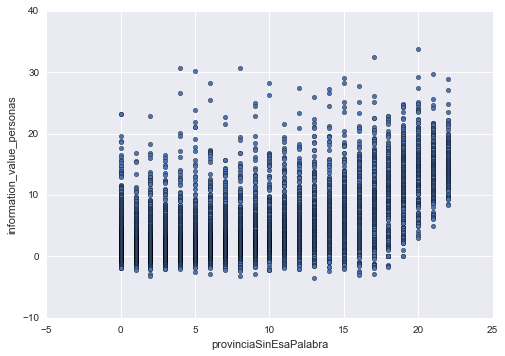

In [33]:
df.plot.scatter(x="provinciaSinEsaPalabra", y="information_value_personas")

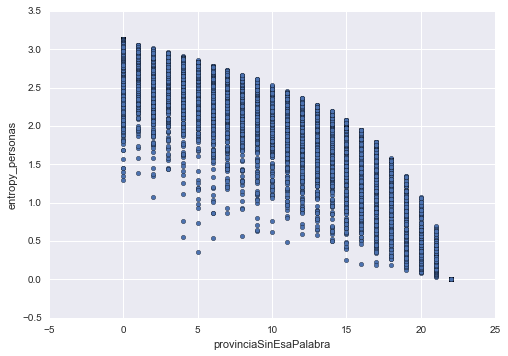

In [34]:
df.plot.scatter(x="provinciaSinEsaPalabra", y="entropy_personas")

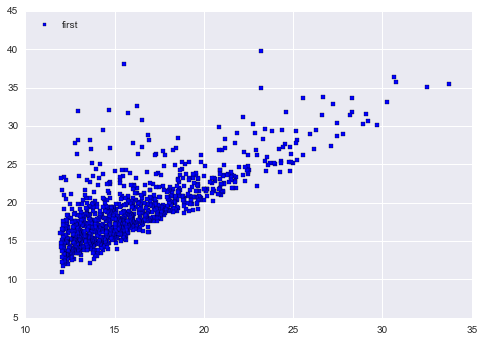

In [35]:
import seaborn
import matplotlib.pyplot as plt

x = df.information_value_personas[:1000]
y = df.information_value_palabras[:1000]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=10, c='b', marker="s", label='first')
plt.legend(loc='upper left');
plt.show()

In [36]:
df[df.provinciaSinEsaPalabra > 17].iloc[:5000][["cantPalabra", "provinciaSinEsaPalabra"]]

,cantPalabra,provinciaSinEsaPalabra
palabra,,
logroño,2592,20
chivil,811,21
sciurano,929,20
ipauss,812,22
plottier,908,20
vallerga,448,22
kraka,382,21
akil,366,20
afrah,375,20


In [37]:
df.cantPalabra.apply(math.log,args=(2,)).describe()

count    75878.000000
mean         7.709320
std          2.102951
min          5.357552
25%          6.108524
50%          7.118941
75%          8.748193
max         22.840220
Name: cantPalabra, dtype: float64

In [38]:
(df.shuffled_entropy_personas - df.entropy_personas).describe()

count    75878.000000
mean         0.142400
std          0.336607
min         -0.591637
25%          0.013417
50%          0.050378
75%          0.136394
max          3.080095
dtype: float64

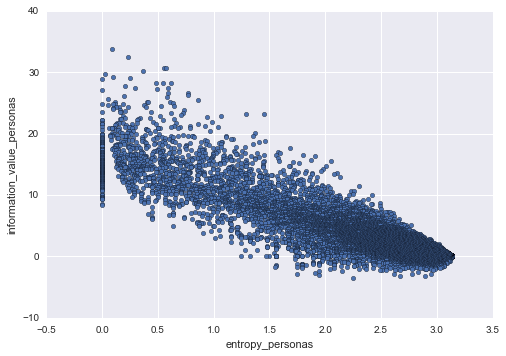

In [39]:
df.plot.scatter(x="entropy_personas", y="information_value_personas")

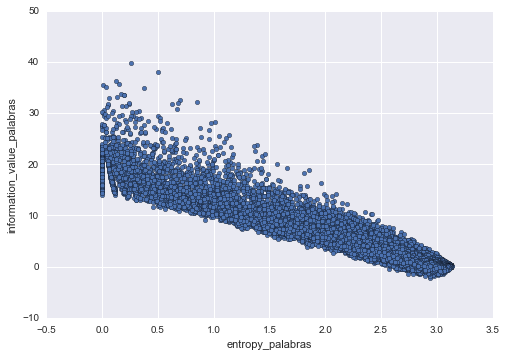

In [40]:
df.plot.scatter(x="entropy_palabras", y="information_value_palabras")

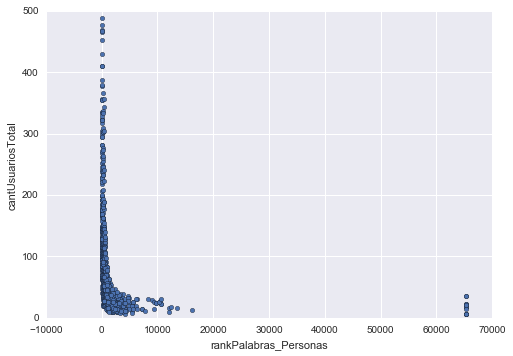

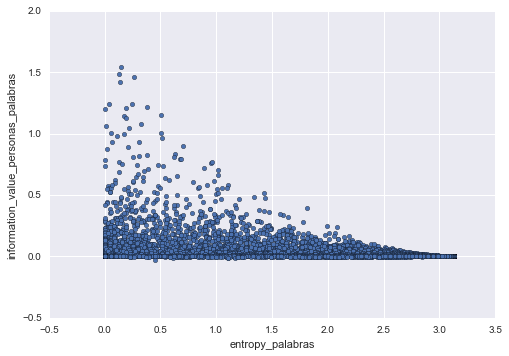

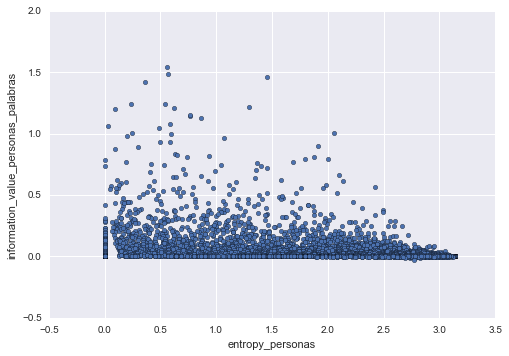

In [41]:
df.iloc[:1000].plot.scatter(x="rankPalabras_Personas", y="cantUsuariosTotal",ylim=[0,500])

df.plot.scatter(x="entropy_palabras", y="information_value_personas_palabras")
df.plot.scatter(x="entropy_personas", y="information_value_personas_palabras")


In [42]:
df.iloc[:5000][df.iloc[:5000].esLugar == 'lugar'].count()

buenosairesPalabras                    535
catamarcaPalabras                      535
chacoPalabras                          535
chubutPalabras                         535
cordobaPalabras                        535
corrientesPalabras                     535
entreriosPalabras                      535
formosaPalabras                        535
jujuyPalabras                          535
lapampaPalabras                        535
lariojaPalabras                        535
mendozaPalabras                        535
misionesPalabras                       535
neuquenPalabras                        535
rionegroPalabras                       535
saltaPalabras                          535
sanjuanPalabras                        535
sanluisPalabras                        535
santacruzPalabras                      535
santafePalabras                        535
santiagoPalabras                       535
tierradelfuegoPalabras                 535
tucumanPalabras                        535
cantPalabra